# InceptionV3 y VGG16 para clasificación de NASH

In [1]:
!pip install tensorflow -q
!pip install keras-tuner -q
!pip install kaggle -q
!pip install scikeras -q

## Importación de librerías

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, Rescaling, Lambda, MaxPooling2D, Conv2D, AveragePooling2D, Activation, Reshape, UpSampling2D, GlobalAveragePooling2D
from keras import backend as K
from keras import applications
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
from sklearn.metrics import roc_auc_score
import os
from google.colab import files
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.callbacks import TensorBoard
import datetime
from sklearn.metrics import classification_report
import os.path as osp
from tensorflow.keras import layers



## Configuración de variables

In [3]:
test_alpha = 0.2
my_seed = 19
batch_size = 64
img_height = 320
img_width = 180
band_count = 3

## Carga de datos

In [4]:
!ls -lha kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download juanjosemontenegro/ecografashigado

-rw-r--r-- 1 root root 74 Nov 25 23:08 kaggle.json
Dataset URL: https://www.kaggle.com/datasets/juanjosemontenegro/ecografashigado
License(s): unknown
100% 1.31G/1.31G [01:08<00:00, 17.3MB/s]
100% 1.31G/1.31G [01:08<00:00, 20.5MB/s]


In [5]:
ROOT_DIR = '/content'
DATASET_NAME = 'ecografashigado'

In [6]:
%cd {ROOT_DIR}
!mkdir /{DATASET_NAME}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

/content
Archive:  ecografashigado.zip
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.42.43 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.42.58 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.43.10 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.43.25 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.43.34 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.43.46 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.43.55 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/58,1 2024-11-19 a la(s) 8.37.10 a. m..jpg  
  inflating: /content/e

In [6]:
DATA_DIR = f"{ROOT_DIR}/{DATASET_NAME}"
print(DATA_DIR)

/content/ecografashigado


## Preprocesamiento y aumentación de datos

In [8]:

def rotate_image(image, label):
    image = tf.image.rot90(image, k=random.randint(1, 3))
    return image, label

def flip_horizontal(image, label):
    image = tf.image.flip_left_right(image)
    return image, label

def flip_vertical(image, label):
    image = tf.image.flip_up_down(image)
    return image, label

def adjust_brightness(image, label):
    image = tf.image.random_brightness(image, max_delta=0.3)
    return image, label

def add_noise(image, label):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)
    return image, label

transformations = [
    rotate_image,
    flip_horizontal,
    flip_vertical,
    adjust_brightness,
    add_noise
]

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    label_mode='categorical',
    validation_split=test_alpha,
    subset="training",
    seed=my_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

augmented_ds_list = []

for transform in transformations:
    augmented_ds = train_ds.map(transform)
    augmented_ds_list.append(augmented_ds)

final_ds = train_ds
for augmented_ds in augmented_ds_list:
    final_ds = final_ds.concatenate(augmented_ds)

train_ds = final_ds.shuffle(buffer_size=1000)

Found 1144 files belonging to 2 classes.
Using 916 files for training.


In [9]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    label_mode='categorical',
    validation_split=test_alpha / 2,
    subset="validation",
    seed=my_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 1144 files belonging to 2 classes.
Using 114 files for validation.


In [10]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    label_mode='categorical',
    validation_split=test_alpha / 2,
    subset="validation",
    seed=my_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 1144 files belonging to 2 classes.
Using 114 files for validation.


In [11]:

class_names = val_ds.class_names
print(class_names)

['Higados Sanos', 'Higados enfermos']


In [12]:

print("----------ENTRENAMIENTO----------")
for images, labels in train_ds.take(1):
  print("Núm. Imágenes:", images.shape)
  print("Clases:", labels.shape)
  #print("Muestra de clases:", labels.numpy())

print("----------VALIDACIÓN----------")
for images, labels in val_ds.take(1):
  print("Núm. Imágenes:", images.shape)
  print("Clases:", labels.shape)
  #print("Muestra de clases:", labels.numpy())

----------ENTRENAMIENTO----------
Núm. Imágenes: (64, 180, 320, 3)
Clases: (64, 2)
----------VALIDACIÓN----------
Núm. Imágenes: (64, 320, 180, 3)
Clases: (64, 2)


## Entrenamiento de redes

### InceptionV3

In [13]:
inc_base_model_obj = InceptionV3(
    input_shape=(img_height, img_width, band_count),
    include_top=False,
    weights="imagenet",
)

inc_base_model_obj.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 320, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 159, 89, 32)    │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 159, 89, 32)    │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 159, 89, 32)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 157, 87, 32)    │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 157, 87, 32)    │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 157, 87, 32)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 157, 87, 64)    │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 157, 87, 64)    │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 157, 87, 64)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 78, 43, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 78, 43, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 78, 43, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 78, 43, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 76, 41, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 76, 41, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [14]:
for layer in inc_base_model_obj.layers:
  layer.trainable = False

#### Ajuste fino

In [15]:
x = inc_base_model_obj.output

In [16]:
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', name='Capa_Densa_1')(x)

In [17]:
predictions = Dense(len(class_names), activation="softmax", name='Capa_Respuesta')(x)

In [18]:
inc_model = Model(inputs=inc_base_model_obj.input, outputs=predictions, name='RCN_Con_Conocimiento_1')

In [19]:
for layer in inc_model.layers:
  if layer.trainable == True:
    print(f"{layer.name}: {layer.trainable}")

global_average_pooling2d: True
Capa_Densa_1: True
Capa_Respuesta: True


In [20]:
inc_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

In [21]:
inc_model.summary()


Model: "RCN_Con_Conocimiento_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 320, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 159, 89, 32)    │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 159, 89, 32)    │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 159, 89, 32)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 157, 87, 32)    │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 157, 87, 32)    │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 157, 87, 32)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 157, 87, 64)    │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 157, 87, 64)    │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 157, 87, 64)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 78, 43, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 78, 43, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 78, 43, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 78, 43, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 76, 41, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 76, 41, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,065,314 (84.17 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [22]:
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5), tensorboard_callback
]

In [24]:
with tf.device('/device:GPU:0'):
  history = inc_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=my_callbacks)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 101s 599ms/step - accuracy: 0.5344 - loss: 8.2428 - val_accuracy: 0.6930 - val_loss: 0.8893
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.6277 - loss: 0.9254 - val_accuracy: 0.7368 - val_loss: 0.5573
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 66ms/step - accuracy: 0.6515 - loss: 0.9733 - val_accuracy: 0.7544 - val_loss: 0.5307
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.7081 - loss: 0.6134 - val_accuracy: 0.6491 - val_loss: 1.1042
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.6928 - loss: 0.7252 - val_accuracy: 0.8070 - val_loss: 0.4264
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.7376 - loss: 0.5601 - val_accuracy: 0.8070 - val_loss: 0.4252
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.7287 - loss: 0.5787 - val_accuracy: 0.8158 - val_loss: 0.4431
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 66ms/step - accuracy: 0.6983 - loss: 0.6563 - val_accuracy: 

#### Gráficas de entrenamiento

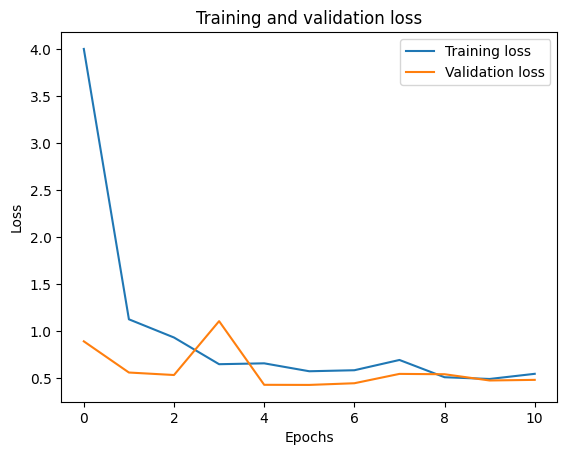

In [25]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

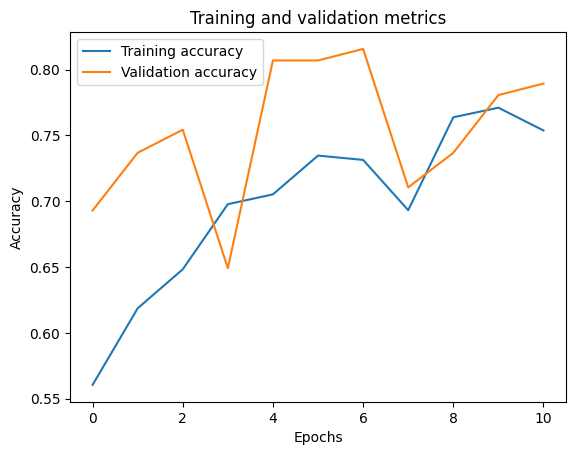

In [26]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Evaluación del modelo

##### Entrenamiento

In [27]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
  pred = inc_model.predict(images)
  for i in range(len(pred)):
    y_true.append(labels[i].numpy())
    y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━

(array([[1., 0.],
        [0., 1.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 array([[1, 0],
        [0, 1],
        [1, 0],
        ...,
        [0, 1],
        [1, 0],
        [0, 1]]))

In [28]:
print(classification_report(y_true, y_pred, target_names=list(class_names)))


                  precision    recall  f1-score   support

   Higados Sanos       0.80      0.83      0.81      3090
Higados enfermos       0.77      0.73      0.75      2406

       micro avg       0.78      0.78      0.78      5496
       macro avg       0.78      0.78      0.78      5496
    weighted avg       0.78      0.78      0.78      5496
     samples avg       0.78      0.78      0.78      5496



##### Validación

In [29]:

y_true = list()
y_pred = list()

for images, labels in val_ds:
  pred = inc_model.predict(images)
  for i in range(len(pred)):
    y_true.append(labels[i].numpy())
    y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


(array([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0

In [30]:
print(classification_report(y_true, y_pred, target_names=list(class_names)))


                  precision    recall  f1-score   support

   Higados Sanos       0.87      0.73      0.80        64
Higados enfermos       0.72      0.86      0.78        50

       micro avg       0.79      0.79      0.79       114
       macro avg       0.79      0.80      0.79       114
    weighted avg       0.80      0.79      0.79       114
     samples avg       0.79      0.79      0.79       114



##### Prueba

In [31]:

y_true = list()
y_pred = list()

for images, labels in test_ds:
  pred = inc_model.predict(images)
  for i in range(len(pred)):
    y_true.append(labels[i].numpy())
    y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


(array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0

In [32]:
print(classification_report(y_true, y_pred, target_names=list(class_names)))


                  precision    recall  f1-score   support

   Higados Sanos       0.87      0.73      0.80        64
Higados enfermos       0.72      0.86      0.78        50

       micro avg       0.79      0.79      0.79       114
       macro avg       0.79      0.80      0.79       114
    weighted avg       0.80      0.79      0.79       114
     samples avg       0.79      0.79      0.79       114



In [33]:
inc_model.save('NASH_inception.h5')

### VGG16

In [34]:

vgg_base_model_obj = VGG16(
    input_shape=(img_height, img_width, band_count),
    include_top=False,
    weights="imagenet",
)

vgg_base_model_obj.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 320, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 320, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 320, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 160, 90, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 160, 90, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 160, 90, 128)        │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 80, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 80, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 80, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 80, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 40, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 40, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 40, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 40, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 20, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 20, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 20, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 20, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 10, 5, 512)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:

for layer in vgg_base_model_obj.layers:
  layer.trainable = False
x = vgg_base_model_obj.output


#### Ajuste fino

In [36]:
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', name='Capa_Densa_1')(x)
x = Dropout(0.2, name='Dropout')(x)
x = Dense(64, activation='relu', name='Capa_Densa_2')(x)

In [37]:
predictions = Dense(len(class_names), activation="softmax", name='Capa_Respuesta')(x)


In [38]:
vgg_model = Model(inputs=vgg_base_model_obj.input, outputs=predictions, name='RCN_Con_Conocimiento_2')


In [39]:

vgg_model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"]
)

In [40]:

log_dir2 = osp.join("logs", "fit2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard2_callback = TensorBoard(log_dir=log_dir2, histogram_freq=1)

In [41]:

my_callbacks2 = [
    tf.keras.callbacks.EarlyStopping(patience=5), tensorboard2_callback
]

In [42]:
vgg_model.summary()


Model: "RCN_Con_Conocimiento_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 320, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 320, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 320, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 160, 90, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 160, 90, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 160, 90, 128)        │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 80, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 80, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 80, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 80, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 40, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 40, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 40, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 40, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 20, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 20, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 20, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 20, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 10, 5, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Densa_1 (Dense)                 │ (None, 128)                 │          65,6

 Total params: 14,788,738 (56.41 MB)

 Trainable params: 74,050 (289.26 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [43]:

with tf.device('/device:GPU:0'):
  history = vgg_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=my_callbacks2)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 66s 322ms/step - accuracy: 0.6374 - loss: 0.9927 - val_accuracy: 0.8333 - val_loss: 0.3295
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.7480 - loss: 0.5037 - val_accuracy: 0.8333 - val_loss: 0.2957
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.8054 - loss: 0.4085 - val_accuracy: 0.7982 - val_loss: 0.3742
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.8222 - loss: 0.3813 - val_accuracy: 0.8684 - val_loss: 0.3043
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.8096 - loss: 0.3737 - val_accuracy: 0.9123 - val_loss: 0.2102
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.8709 - loss: 0.2768 - val_accuracy: 0.8860 - val_loss: 0.2657
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.8982 - loss: 0.2267 - val_accuracy: 0.8772 - val_loss: 0.2530
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.8815 - loss: 0.2704 - val_accuracy: 0

#### Gráficas de entrenamiento

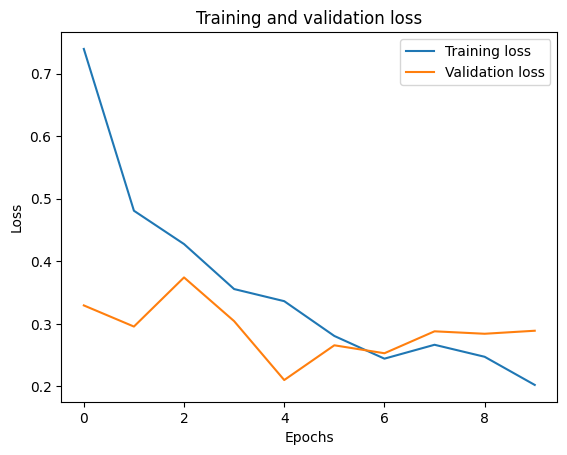

In [44]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


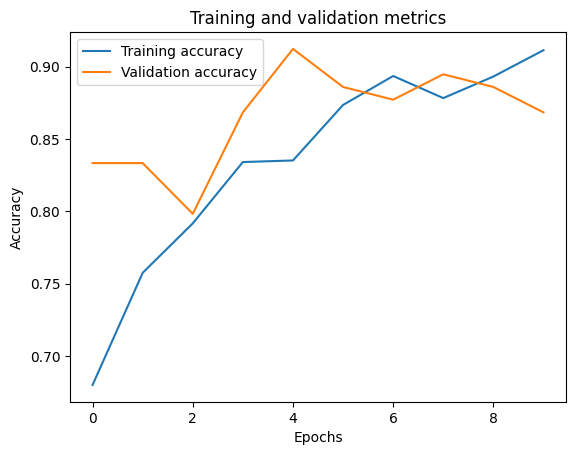

In [45]:

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Evaluación del modelo

##### Entrenamiento

In [46]:


y_true = list()
y_pred = list()

for images, labels in train_ds:
  pred = vgg_model.predict(images)
  for i in range(len(pred)):
    y_true.append(labels[i].numpy())
    y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━

(array([[1., 0.],
        [1., 0.],
        [0., 1.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 array([[0, 1],
        [1, 0],
        [0, 1],
        ...,
        [0, 1],
        [1, 0],
        [1, 0]]))

In [48]:
print(classification_report(y_true, y_pred, target_names=list(class_names)))


                  precision    recall  f1-score   support

   Higados Sanos       0.91      0.98      0.94      3090
Higados enfermos       0.97      0.88      0.92      2406

       micro avg       0.93      0.93      0.93      5496
       macro avg       0.94      0.93      0.93      5496
    weighted avg       0.94      0.93      0.93      5496
     samples avg       0.93      0.93      0.93      5496



##### Validación

In [49]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
  pred = vgg_model.predict(images)
  for i in range(len(pred)):
    y_true.append(labels[i].numpy())
    y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


(array([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1

In [50]:
print(classification_report(y_true, y_pred, target_names=list(class_names)))


                  precision    recall  f1-score   support

   Higados Sanos       0.89      0.88      0.88        64
Higados enfermos       0.84      0.86      0.85        50

       micro avg       0.87      0.87      0.87       114
       macro avg       0.87      0.87      0.87       114
    weighted avg       0.87      0.87      0.87       114
     samples avg       0.87      0.87      0.87       114



##### Prueba

In [51]:
y_true = list()
y_pred = list()

for images, labels in test_ds:
  pred = vgg_model.predict(images)
  for i in range(len(pred)):
    y_true.append(labels[i].numpy())
    y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


(array([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0

In [52]:
print(classification_report(y_true, y_pred, target_names=list(class_names)))


                  precision    recall  f1-score   support

   Higados Sanos       0.89      0.88      0.88        64
Higados enfermos       0.84      0.86      0.85        50

       micro avg       0.87      0.87      0.87       114
       macro avg       0.87      0.87      0.87       114
    weighted avg       0.87      0.87      0.87       114
     samples avg       0.87      0.87      0.87       114



In [54]:
vgg_model.save('NASH_vgg.keras')